In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from transformers import BertModel,BertTokenizer,get_linear_schedule_with_warmup
from torch.utils.data import DataLoader,Dataset
import numpy as np
import warnings
warnings.filterwarnings("ignore")


device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

df = pd.read_csv("C:/nlp_projects/spam/Spam_SMS.csv",delimiter=',')
print(df.isna().sum())
print(df.duplicated().sum())
df.head(10)

cuda
Class      0
Message    0
dtype: int64
415


,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


415


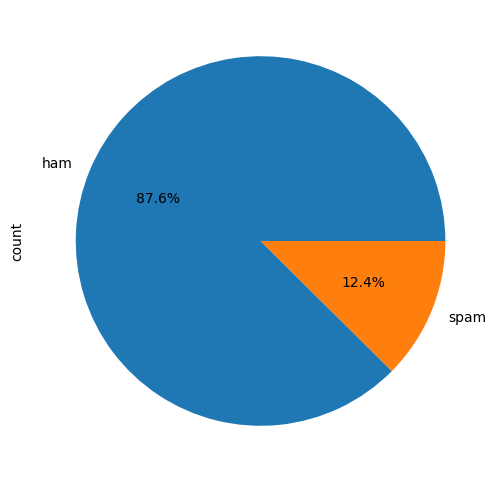

In [2]:

print(df.duplicated().sum())
df.drop_duplicates(inplace=True)


plt.figure(figsize=(10,6))
df['Class'].value_counts().plot(kind='pie',autopct="%1.1f%%")
plt.show()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


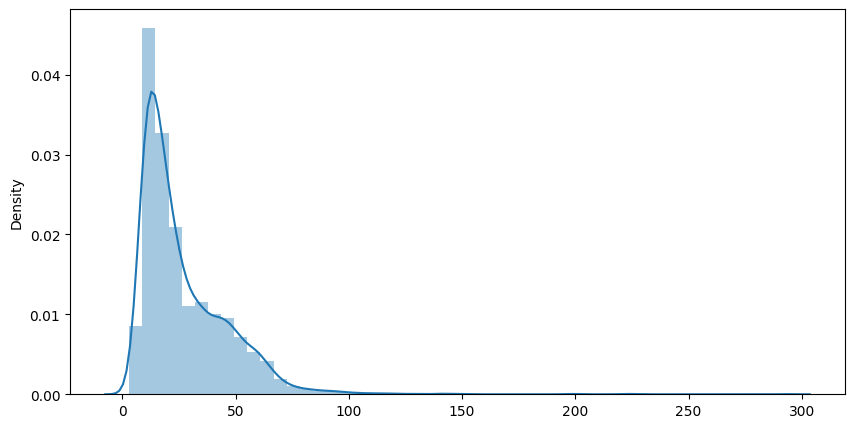

In [3]:
df['Class'] = [1 if X == "ham" else 0 for X in df['Class']]



MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


sample_tokens = []
for txt in df['Message']:
    tokens = tokenizer.encode(txt, max_length=512)
    sample_tokens.append(len(tokens))



plt.figure(figsize=(10,5))
sns.distplot(sample_tokens)
plt.show()

In [4]:

max_length = 128

class SPAM_Dataset(Dataset):
    def __init__(self,Message,targets,max_len,tokenizer):
        self.Message = Message
        self.targets = targets
        self.max_len = max_len
        self.tokenizer = tokenizer
        
        
        
    def __len__(self):
        return len(self.Message)
    
    
    def __getitem__(self,idx):
        Message = str(self.Message[idx])
        target = self.targets[idx]


        encoder = self.tokenizer.encode_plus(
        Message,
        max_length=self.max_len,
        padding='max_length',
        truncation=True,
        add_special_tokens=True,
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
        )
    
        return {
        "Message":Message,
        "input_ids":encoder['input_ids'].flatten(),
        "attention_mask":encoder['attention_mask'].flatten(),
        "targets":torch.tensor(target,dtype=torch.long)
        }



from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,test_size=.20,random_state=42)
df_val,df_test = train_test_split(df_test, test_size=.50,random_state=42)



def get_dataloader(df,max_len,tokenizer,batch_size):
    ds = SPAM_Dataset(
        Message = df['Message'].to_numpy(),
        targets = df['Class'].to_numpy(),
        max_len=max_len,
        tokenizer=tokenizer,
        )
    return DataLoader(
        ds,
        num_workers=0,
        batch_size=batch_size
        )


BATCH_SIZE = 12

train_dataloader = get_dataloader(df_train, max_len=max_length, tokenizer=tokenizer, batch_size=BATCH_SIZE)
test_dataloader = get_dataloader(df_test, max_len=max_length, tokenizer=tokenizer, batch_size=BATCH_SIZE)
val_dataloader = get_dataloader(df_val, max_len=max_length, tokenizer=tokenizer, batch_size=BATCH_SIZE)


data = next(iter(train_dataloader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['Message', 'input_ids', 'attention_mask', 'targets'])
torch.Size([12, 128])
torch.Size([12, 128])
torch.Size([12])


In [5]:

class Bert_Classifier(nn.Module):
    def __init__(self, n_classes=2):
        super(Bert_Classifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(768,2)
    

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)



model = Bert_Classifier(2)
model.to(device)

Bert_Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [6]:

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)
num_epochs = 4
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)




def training_epoch(model,dataloader,loss_fn,optimizer,device,scheduler,n_examples):
    model.train()
    losses = []
    predictions = 0
    for d in dataloader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        outputs = model(
            attention_mask=attention_mask,
            input_ids=input_ids
            )
        _,preds = torch.max(outputs,dim=1)
        loss = loss_fn(outputs,targets)
        predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return (predictions.double() / n_examples,np.mean(losses))




def eval_model(model,dataloader,loss_fn,device,n_examples):
    model = model.eval()
    losses = []
    predictions = 0
    
    
    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
            
            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
                )
            
            _,preds = torch.max(outputs,dim=1)
            loss = loss_fn(outputs,targets)
            
            predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
        return (predictions.double() / n_examples,np.mean(losses))






for epoch in range(num_epochs):
    print(f'{epoch+1}/{num_epochs}')
    
    train_acc, train_loss = training_epoch(
        model,
        train_dataloader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    val_acc, val_loss = eval_model(
    model,
    val_dataloader,
    loss_fn,
    device,
    len(df_val)
)
    print(f" Training accuracy {train_acc*100:.2f}%; -Val Accuracy-- {val_acc*100:.2f}%")
    print(f"training loss {train_loss*100:.2f}%; --val loss-- {val_loss*100:.2f}%")
    



test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(df_test)
)

print(f'Testing Accuracy : {test_acc.item() *100 :.2f}%')

1/4
 Training accuracy 96.17%; -Val Accuracy-- 98.84%
training loss 9.60%; --val loss-- 4.73%
2/4
 Training accuracy 99.30%; -Val Accuracy-- 95.93%
training loss 2.65%; --val loss-- 9.24%
3/4
 Training accuracy 99.59%; -Val Accuracy-- 97.67%
training loss 1.01%; --val loss-- 8.15%
4/4
 Training accuracy 99.64%; -Val Accuracy-- 97.87%
training loss 1.30%; --val loss-- 11.75%
Testing Accuracy : 99.03%


In [ ]:

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score


def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for d in dataloader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                attention_mask=attention_mask,
                input_ids=input_ids
            )

            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    return all_labels, all_preds





true_labels, predicted_labels = get_predictions(model, test_dataloader, device)

clf_rpt = classification_report(true_labels,predicted_labels)
print(f'Classification Report: {clf_rpt}')

f1 = f1_score(true_labels,predicted_labels)
print(f'The weighted f1 score: {f1*100:.2f}%')


acc = accuracy_score(true_labels,predicted_labels)
print(f' --Accuracy Score-- {acc*100:.2f}')


def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Spam","Ham"], yticklabels=["Spam","Ham"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


plot_confusion_matrix(true_labels, predicted_labels)